In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import xgboost
import shap

from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score


In [2]:
from F2_train_test_split_functions import func_test_train_split_msoa_single

### Classification using Shapley values

In this notebook, we run the tuned XGBoost classifier wrapped with the Shapley package to predict the features deciding the result for each local MSOA region.

The hyperparameters are derived in the M1 modelling notebook.

In [3]:
df = pd.read_csv('data/msoa_today_steady.csv')
print(df.shape)
df.head()

(5740, 12)


,MSOA11CD,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,RUC11,msoa11cd,ev_count,pv_count_2020,public_chargers_2021,private_chargers_2021,elec_consumption_2019
0,E02004297,40650.0,129990.000000,20450.20,6.0,Rural town and fringe,E02004297,2,41,11.090909,15.378788,15387.466659
1,E02004290,43260.0,135343.750000,21972.50,8.0,Urban major conurbation,E02004290,1,70,11.090909,15.378788,12941.948564
2,E02004298,40635.0,136866.666667,18949.50,6.5,Urban city and town,E02004298,4,111,11.090909,15.378788,19825.929444
3,E02004299,34450.0,109200.000000,10635.60,4.0,Urban city and town,E02004299,1,50,11.090909,15.378788,14636.314372
4,E02004291,34730.0,95375.000000,7844.25,2.5,Urban major conurbation,E02004291,0,35,11.090909,15.378788,11049.599268


In [4]:
df['ev_present']=(df['ev_count']>0).values.astype(int)

In [5]:
# drop count variable, as we just want to predict present or not
df.drop(columns=['ev_count'], inplace=True)

In [6]:
# One hot encode our one classification variable: RUC11
df = pd.concat([df, pd.get_dummies(df['RUC11'])],axis=1)
df.drop(columns=['RUC11'],inplace=True)

In [7]:
# drop duplicated msoa code column and set the remaining one at the index
df.drop(columns=['msoa11cd'], inplace=True)
df.set_index(['MSOA11CD'],inplace=True)

In [8]:
y = df[['ev_present']]
X = df.drop(columns=['ev_present'])

In [9]:
X_train, y_train, X_test, y_test = func_test_train_split_msoa_single(X,y,0.7,45)

In [10]:
X_train.head()

,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,pv_count_2020,public_chargers_2021,private_chargers_2021,elec_consumption_2019,Rural town and fringe,Rural town and fringe in a sparse setting,Rural village and dispersed,Rural village and dispersed in a sparse setting,Urban city and town,Urban city and town in a sparse setting,Urban major conurbation,Urban minor conurbation
MSOA11CD,,,,,,,,,,,,,,,,
E02004556,53020.0,451687.500,25777.75,8.5,48,3.625000,19.375000,25778.018227,1,0,0,0,0,0,0,0
E02004572,43865.0,315399.000,19402.80,6.0,10,7.000000,19.100000,19722.251722,0,0,1,0,0,0,0,0
E02002160,39820.0,162000.000,14350.00,4.5,27,5.939394,7.272727,13833.048185,0,0,0,0,0,0,1,0
E02002301,34835.0,105500.000,6420.50,2.0,20,6.135593,14.847458,12337.077358,0,0,0,0,0,0,1,0
E02002920,40390.0,235061.875,21617.75,7.5,31,17.304348,19.956522,14675.423653,0,0,0,0,1,0,0,0


## Classify with Shapely

In [11]:
# train an XGBoost model
model = xgboost.XGBClassifier(use_label_encoder=False,
                          learning_rate=0.01,  
                          colsample_bytree=0.9,
                          subsample=0.5,
                          objective='binary:logistic', 
                          n_estimators=500, 
                          max_depth=4,
                          gamma=1).fit(X_train, y_train)
print(cross_val_score(model, X_train, y_train, cv=5).mean())
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)

[11:38:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:38:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:38:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:38:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [12]:
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


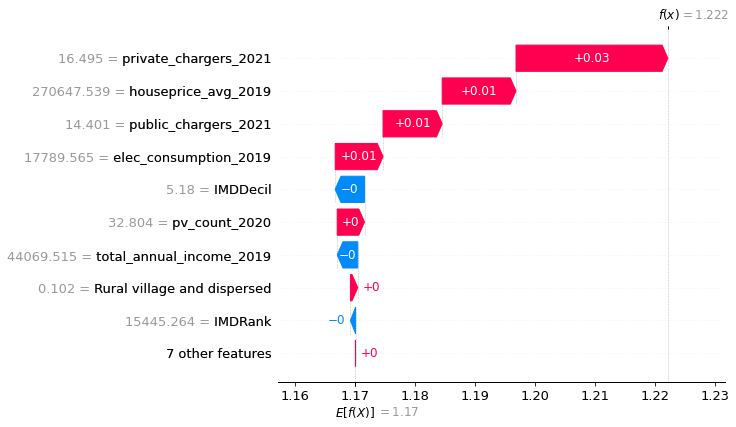

In [13]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values.mean(axis=0))

In [14]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

In [15]:
confusion_matrix(y_test,y_pred)


array([[   7,  385],
       [   5, 1326]])

In [16]:
tp_index = []
tn_index = []
fn_index = []
fp_index = []

for i in range(len(y_pred)):
    if (y_test.ev_present[i] == 1) and (y_pred[i] == 1):
        tp_index.append(i)
    elif (y_test.ev_present[i] == 1) and (y_pred[i] == 0):
        fn_index.append(i)
    elif (y_test.ev_present[i] == 0) and (y_pred[i] == 1):
        fp_index.append(i)
    elif (y_test.ev_present[i] == 0) and (y_pred[i] == 0):
        tn_index.append(i)

In [17]:
msoa_test = y_test.index
msoa_test_tp = msoa_test[tp_index]
msoa_test_fn = msoa_test[fn_index]
msoa_test_fp = msoa_test[fp_index]
msoa_test_tn = msoa_test[tn_index]

y_test.loc[msoa_test_tp,'clf_label'] = 'TP'#tp
y_test.loc[msoa_test_tn,'clf_label'] = 'TN'#tn
y_test.loc[msoa_test_fp,'clf_label'] = 'FP'#fp
y_test.loc[msoa_test_fn,'clf_label'] = 'FN'

In [18]:
[i for i, x in enumerate(y_test.index == msoa_test[fp_index][0]) if x]

[0]

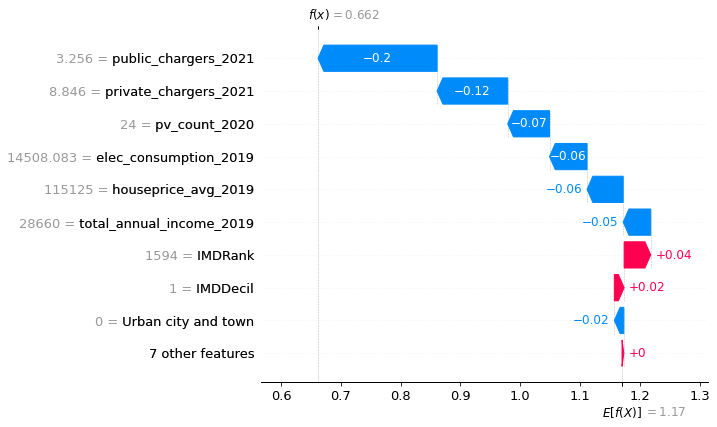

In [19]:
# visualise Shapley values for a FP
shap.plots.waterfall(shap_values[1])

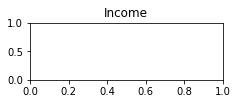

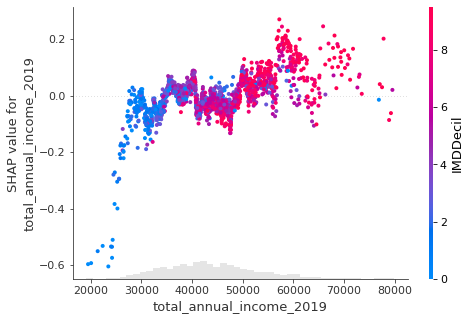

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


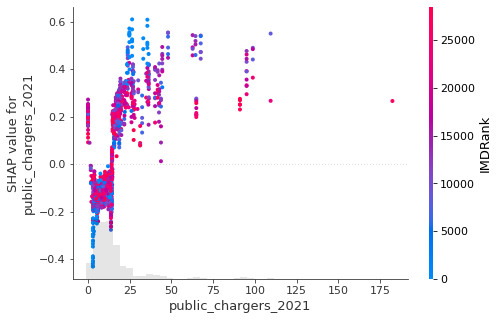

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


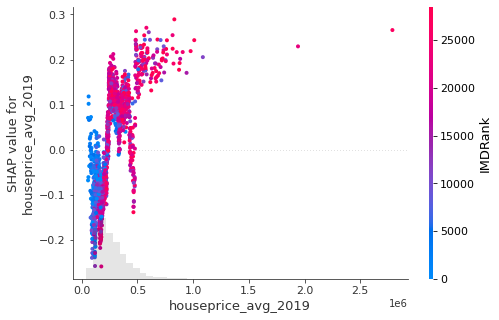

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


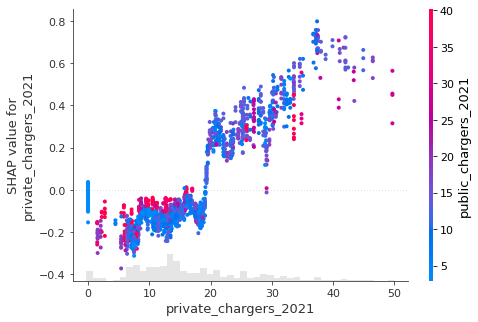

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


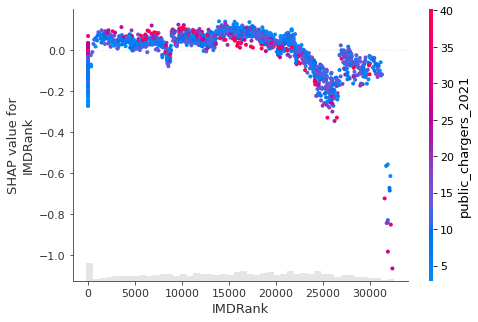

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


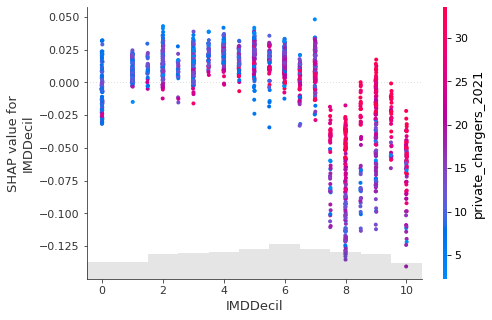

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


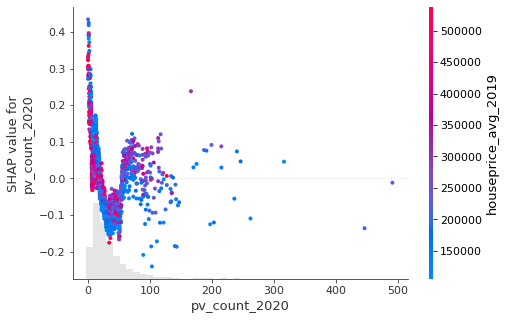

In [20]:
fig = plt.figure(constrained_layout=True)
grid = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

ax1 = fig.add_subplot(grid[0, 0])
ax1.set_title('Income')
ax1 = shap.plots.scatter(shap_values[:,"total_annual_income_2019"], color=shap_values)

ax2 = fig.add_subplot(grid[0, 1])
ax2.set_title('Public Chargers')
ax2= shap.plots.scatter(shap_values[:,"public_chargers_2021"], color=shap_values)

ax3 = fig.add_subplot(grid[1, :1])
ax3.set_title('Houseprice')
ax3 = shap.plots.scatter(shap_values[:,"houseprice_avg_2019"], color=shap_values)

ax4 = fig.add_subplot(grid[1, 1:])
ax4.set_title('Private chargers')
ax4= shap.plots.scatter(shap_values[:,"private_chargers_2021"], color=shap_values)

ax5 = fig.add_subplot(grid[2, :1])
ax5.set_title('IMD Rank')
ax5 = shap.plots.scatter(shap_values[:,"IMDRank"], color=shap_values)

ax6 = fig.add_subplot(grid[2, 1:])
ax6.set_title('IMD Decil')
ax6= shap.plots.scatter(shap_values[:,"IMDDecil"], color=shap_values)

ax7 = fig.add_subplot(grid[3, :1])
ax7.set_title('PV count')
ax7 = shap.plots.scatter(shap_values[:,'pv_count_2020'], color=shap_values)


## Visualise on a map

In [21]:
msoa_geom = gpd.read_file('data/Middle_Layer_Super_Output_Areas_(December_2011)_Boundaries.geojson')

In [22]:
msoa_geom.to_crs({'init': 'epsg:27700'}, inplace=True)

In [23]:
print(df.shape)
print(msoa_geom.shape)

(5740, 17)
(7201, 7)


In [24]:
msoa_geom=msoa_geom[['msoa11cd', 'geometry']]

In [25]:
print(msoa_geom.columns)
print(df.reset_index().columns)

Index(['msoa11cd', 'geometry'], dtype='object')
Index(['MSOA11CD', 'total_annual_income_2019', 'houseprice_avg_2019',
       'IMDRank', 'IMDDecil', 'pv_count_2020', 'public_chargers_2021',
       'private_chargers_2021', 'elec_consumption_2019', 'ev_present',
       'Rural town and fringe', 'Rural town and fringe in a sparse setting',
       'Rural village and dispersed',
       'Rural village and dispersed in a sparse setting',
       'Urban city and town', 'Urban city and town in a sparse setting',
       'Urban major conurbation', 'Urban minor conurbation'],
      dtype='object')


In [26]:
df_geom = msoa_geom.merge(df.reset_index(), left_on='msoa11cd', right_on='MSOA11CD', how='inner')
df_test_geom = msoa_geom.merge(y_test.reset_index(), left_on='msoa11cd', right_on='MSOA11CD', how='inner')
df_train_geom = msoa_geom.merge(y_train.reset_index(), left_on='msoa11cd', right_on='MSOA11CD', how='inner')


In [27]:
df_test_geom[df_test_geom['clf_label']=='FP']

,msoa11cd,geometry,MSOA11CD,ev_present,clf_label
0,E02000015,"POLYGON ((549966.487 184818.973, 549966.336 18...",E02000015,0,FP
6,E02000075,"POLYGON ((549006.697 177407.520, 549007.261 17...",E02000075,0,FP
14,E02000114,"POLYGON ((522790.937 185005.528, 522786.582 18...",E02000114,0,FP
22,E02000149,"POLYGON ((546262.886 168864.293, 546273.383 16...",E02000149,0,FP
25,E02000159,"POLYGON ((542620.699 166324.063, 542621.265 16...",E02000159,0,FP
...,...,...,...,...,...
1710,W02000328,"POLYGON ((329757.632 199725.730, 329754.802 19...",W02000328,0,FP
1716,W02000379,"POLYGON ((323422.386 181490.778, 323422.189 18...",W02000379,0,FP
1717,W02000381,"POLYGON ((321854.395 181306.049, 321854.788 18...",W02000381,0,FP
1719,W02000400,"POLYGON ((316937.602 178248.891, 316922.591 17...",W02000400,0,FP


## Look at individual FPs to find interesting region

In [28]:
def func_get_msoa_neighbours(msoa, df_geom):
    """Function to pull neighbours of the MSOA region from the full dataset df_geom."""
    msoa_row = df_geom[df_geom['msoa11cd'] == msoa]

    for index, row in msoa_row.iterrows():   

        # get 'not disjoint' countries
        neighbours = msoa_geom[~msoa_geom.geometry.disjoint(row.geometry)].msoa11cd.tolist()

        # remove own name of the country from the list
        neighbours = [ candidate for candidate in neighbours if candidate != msoa ]

    return neighbours

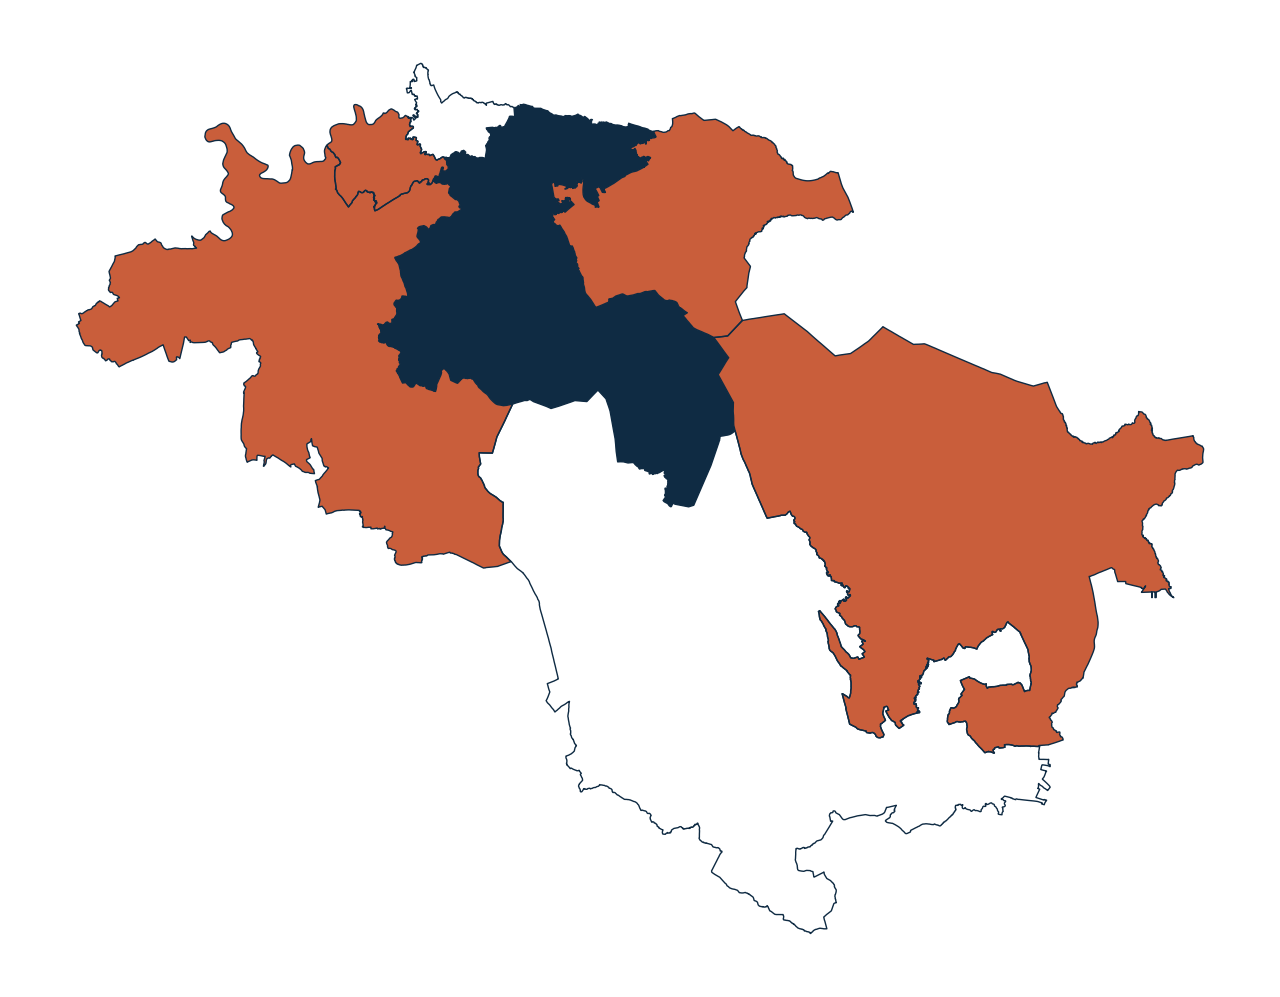

In [30]:
msoa_fp_sample ='E02005751'# np.random.choice(msoa_test_fp)
neighbours = func_get_msoa_neighbours(msoa_fp_sample, msoa_geom)

# plot msoa region and its neighbours
fig, ax = plt.subplots(figsize=(8,14), dpi=200)
df_geom[df_geom['msoa11cd']==msoa_fp_sample].plot(ax=ax, color='#0f2b43')
df_geom[df_geom['msoa11cd'].isin(neighbours)].boundary.plot(ax=ax, color='#0f2b43',linewidth=0.5)
#df_geom.plot(ax=ax, color='#eeeeec')
#df_geom.boundary.plot(ax=ax, linewidth=0.1, color='#0f2b43')
df_geom[df_geom['msoa11cd'].isin(neighbours) & df_geom['ev_present']==1].plot(ax=ax, color='#c95e3b')
plt.axis('off')
plt.savefig('msoa_E02005751.png', transparent=True)

In [186]:
msoa_fp_sample

'E02000886'

In [187]:
df_geom[df_geom['msoa11cd'].isin(neighbours)]

,msoa11cd,geometry,MSOA11CD,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,pv_count_2020,public_chargers_2021,private_chargers_2021,elec_consumption_2019,ev_present,Rural town and fringe,Rural town and fringe in a sparse setting,Rural village and dispersed,Rural village and dispersed in a sparse setting,Urban city and town,Urban city and town in a sparse setting,Urban major conurbation,Urban minor conurbation
569,E02000877,"POLYGON ((536912.775 182451.430, 536911.754 18...",E02000877,50250.0,479267.000000,7636.20,3.0,38,19.96875,2.0625,13384.695326,1,0,0,0,0,0,0,1,0
571,E02000882,"POLYGON ((536522.945 181537.804, 536523.670 18...",E02000882,54405.0,389924.935611,5490.75,2.0,1,19.96875,2.0625,12784.699437,0,0,0,0,0,0,0,1,0
575,E02000888,"POLYGON ((536353.371 181121.086, 536314.261 18...",E02000888,66810.0,447940.000000,12966.20,4.0,0,19.96875,2.0625,20777.607125,1,0,0,0,0,0,0,1,0


In [188]:
df_geom[df_geom['msoa11cd']==msoa_fp_sample]

,msoa11cd,geometry,MSOA11CD,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,pv_count_2020,public_chargers_2021,private_chargers_2021,elec_consumption_2019,ev_present,Rural town and fringe,Rural town and fringe in a sparse setting,Rural village and dispersed,Rural village and dispersed in a sparse setting,Urban city and town,Urban city and town in a sparse setting,Urban major conurbation,Urban minor conurbation
574,E02000886,"POLYGON ((536575.882 181512.469, 536575.382 18...",E02000886,61160.0,486875.0,10729.5,3.5,2,19.96875,2.0625,14343.822897,0,0,0,0,0,0,0,1,0


ev_present     0
clf_label     FP
Name: E02005751, dtype: object


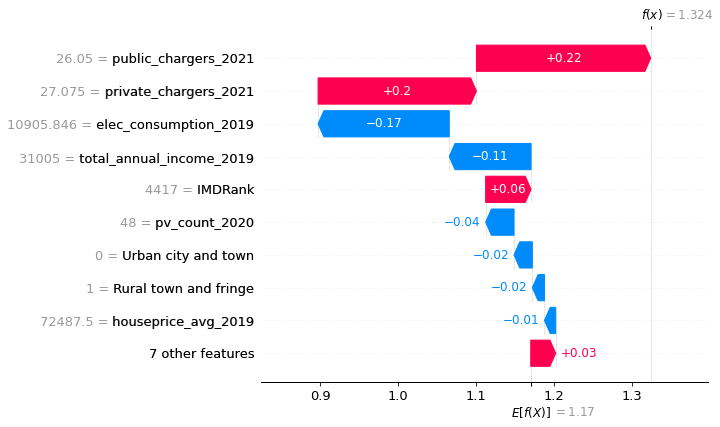

In [176]:
y_test.loc[msoa_fp_sample]
index_single=  [i for i, x in enumerate(y_test.index == msoa_fp_sample) if x]
print(y_test.iloc[1673])
shap.plots.waterfall(shap_values[index_single[0]])

In [195]:
y_pred_prob[index_single]

array([[0.21016365, 0.78983635]], dtype=float32)

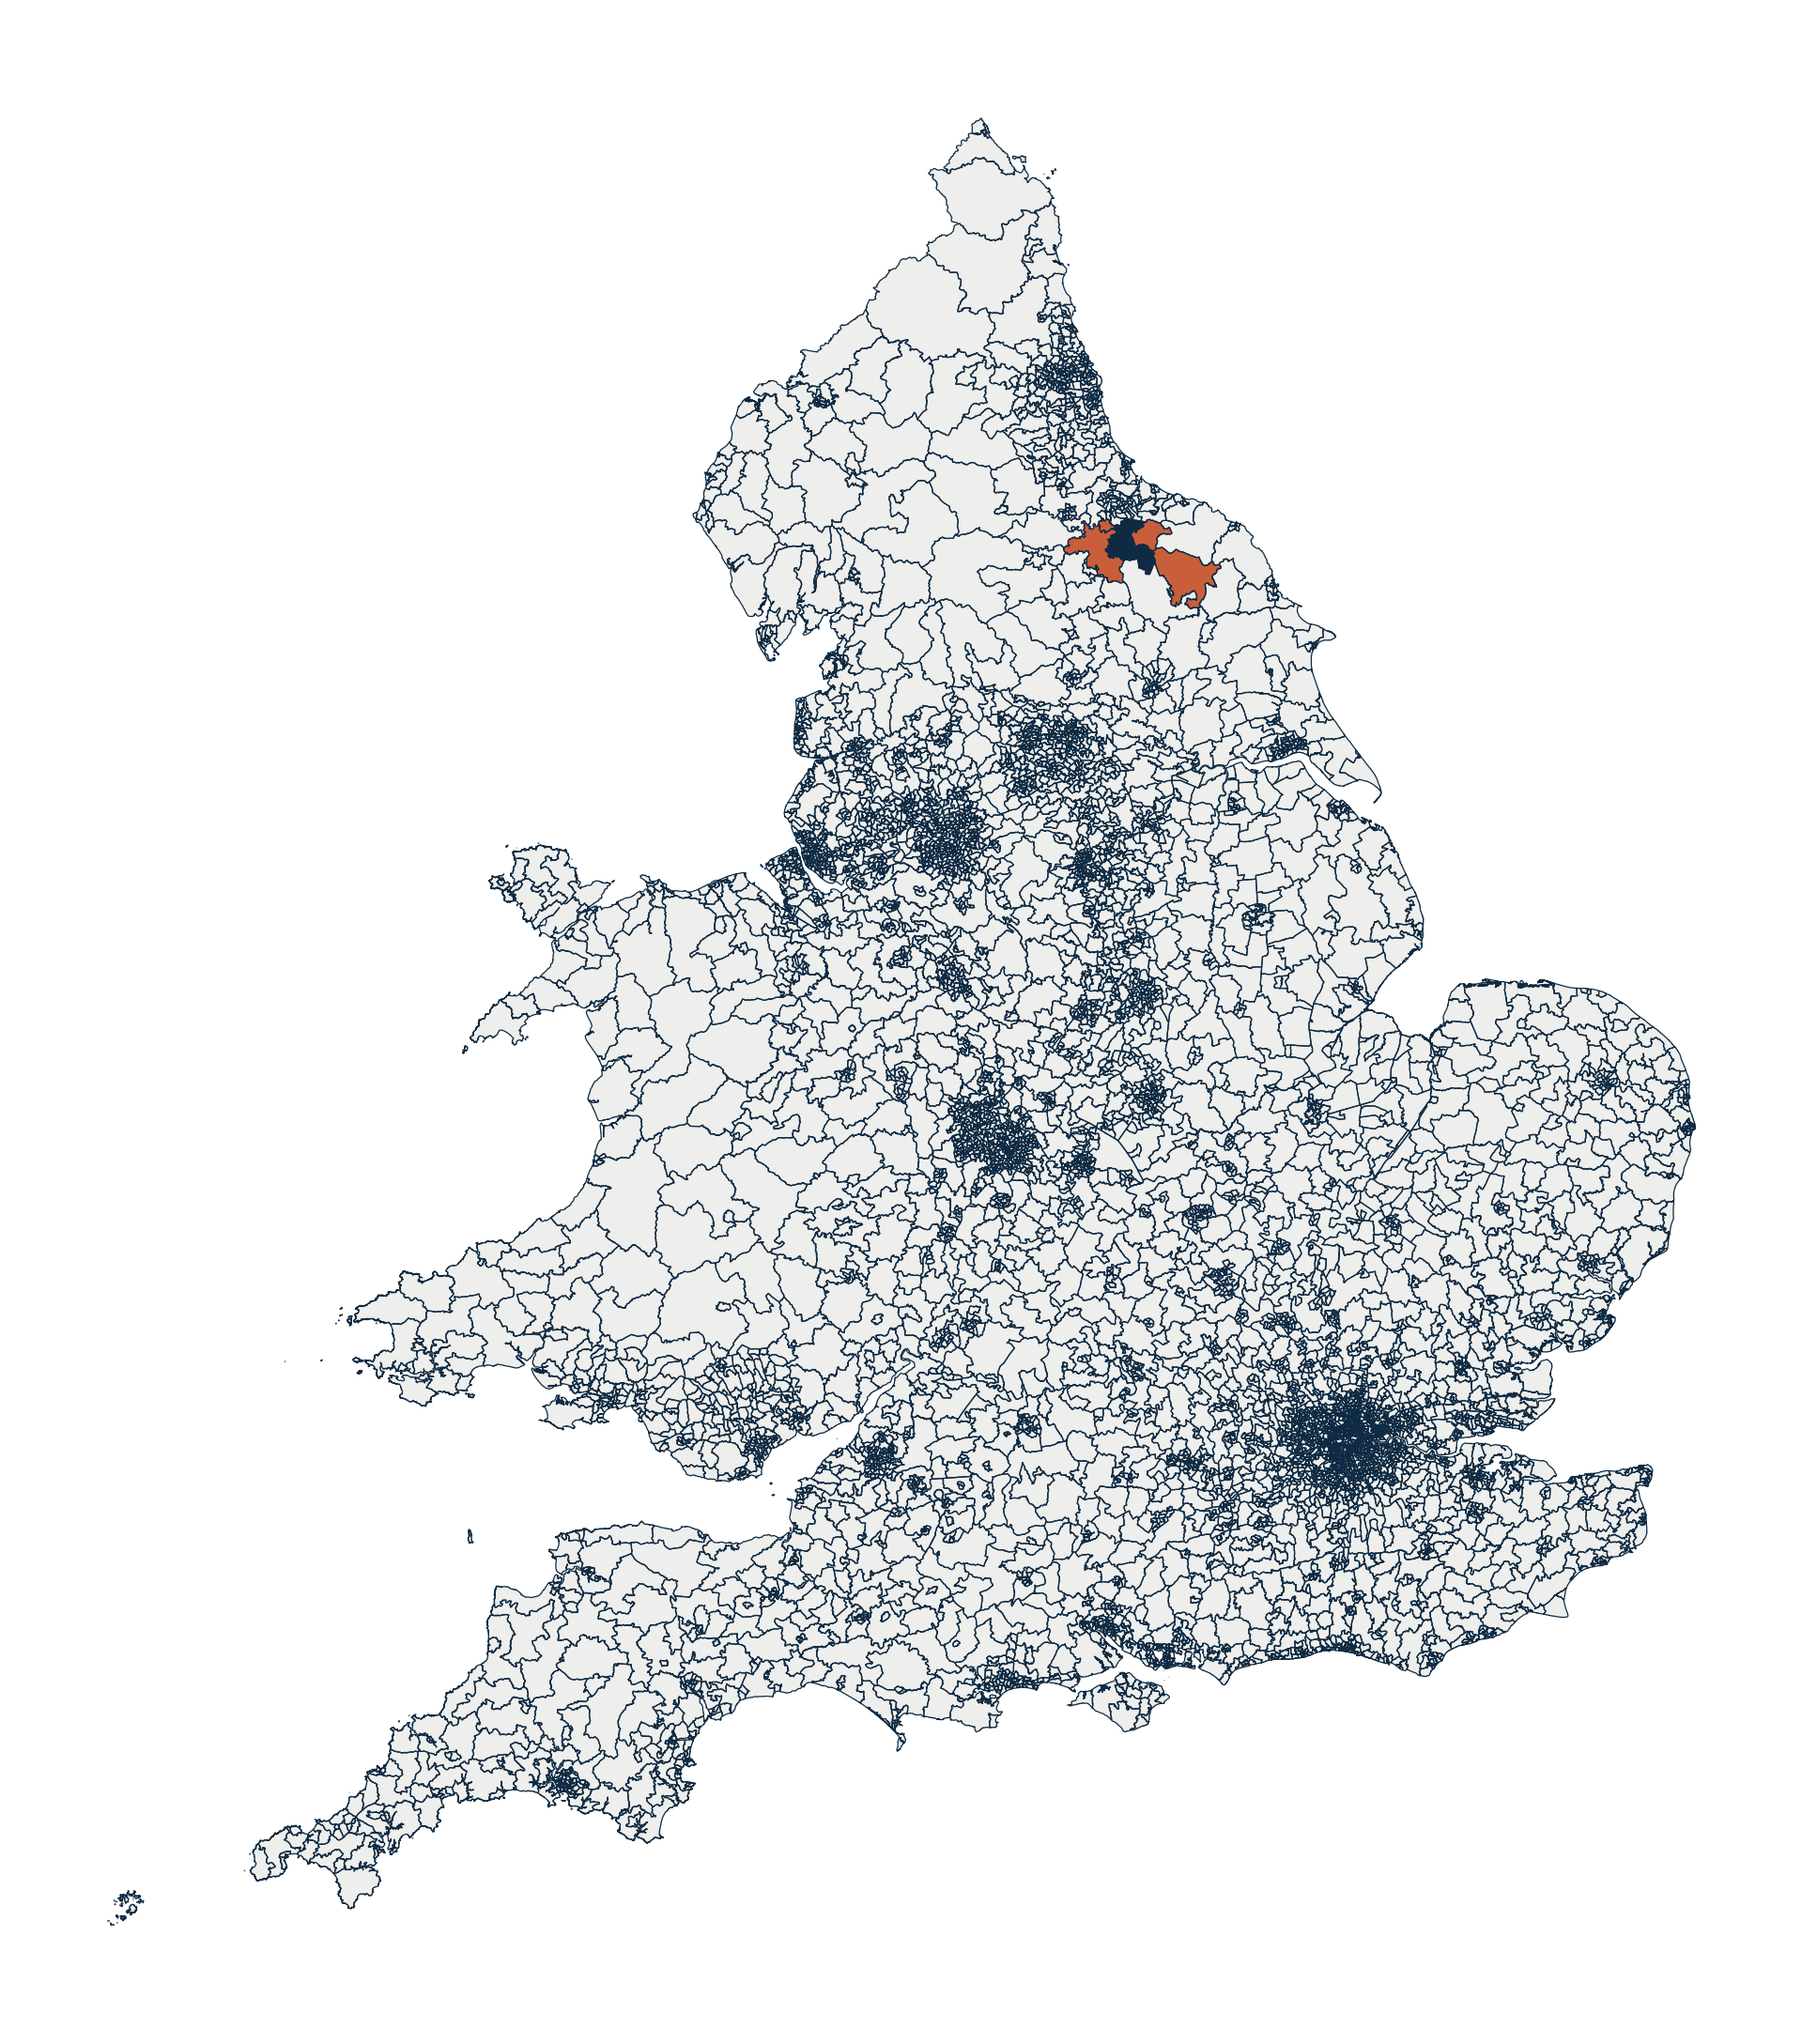

In [35]:
msoa_fp_sample ='E02005751'# np.random.choice(msoa_test_fp)
neighbours = func_get_msoa_neighbours(msoa_fp_sample, msoa_geom)

# plot msoa region and its neighbours
fig, ax = plt.subplots(figsize=(8,14), dpi=300)
msoa_geom.plot(ax=ax, color='#eeeeec')
msoa_geom.boundary.plot(ax=ax, linewidth=0.3, color='#0f2b43')
msoa_geom[msoa_geom['msoa11cd']==msoa_fp_sample].plot(ax=ax, color='#0f2b43')
#msoa_geom[msoa_geom['msoa11cd'].isin(neighbours)].plot(ax=ax, color='#c95e3b',linewidth=0.5)
df_geom[df_geom['msoa11cd'].isin(neighbours) & df_geom['ev_present']==1].plot(ax=ax, color='#c95e3b')
plt.axis('off')
#plt.savefig('msoa_E02005751.png', transparent=True)#

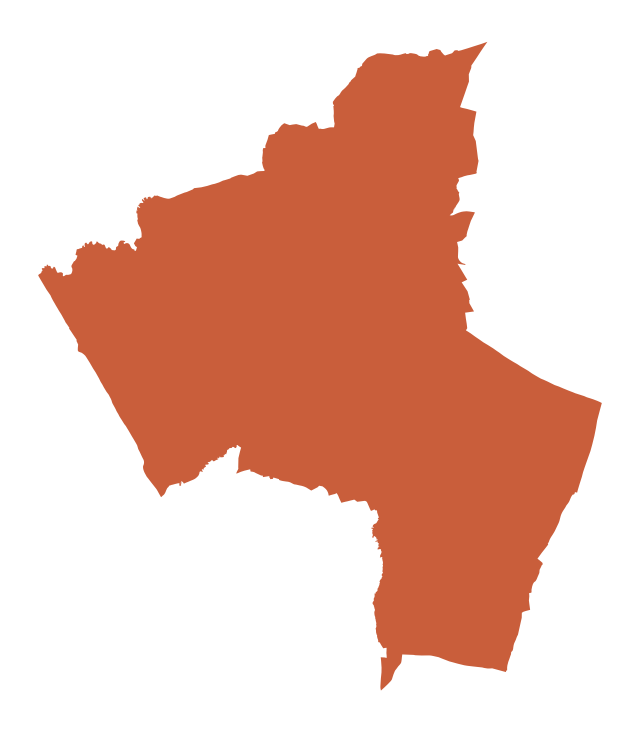

In [150]:
# plots some MSOA regions
msoa_sample = np.random.choice(msoa_test_tp)

fig, ax = plt.subplots(figsize=(8,14), dpi=100)
msoa_geom[msoa_geom['msoa11cd']==msoa_sample].plot(linewidth=5,ax=ax,color='#c95e3b')
plt.axis('off')